## 定位模型

- **在第一次作业的b小题中，我们的定位模型是**：在完成每个分组的MR记录相对位置计算之后，针对每个分组构建一个对应的MR定位模型，不过该模型是以MR记录与主基站的相对位置作为标签。使用处理好的训练集用于训练模型，测试数据集用于测试统计，通过上述随机森林模型预测测试数据的相对位置。有趣的是，我第一次作业中人为-999的填充太随便了，然后分析后发现缺失的辅助基站数据很有可能是现实中根本不存在该基站，所有没有采取填充的方法。同时，为了解决缺失数据的问题，我在分组的基础上又根据缺失值进行分组，导致误差高的离谱。这里一个主要的原因就是，存在一些主基站分组中只有3条MR数据，而着3条MR数据中的缺失情况也可能不一样，这就导致可能训练时只有一条数据，然后进行预测，误差几乎就是随机值，所有最终的平均误差高达2000左右。在第2次作业中，我对第一次作业中进行了一些改动，采用-999的填充方案，并将所有属性作为特征，使用随机森林进行回归预测，所有组的平均误差和为6.2左右！！！

- **在此次作业的a和b两个小问中**：主要工作使使用每个主基站分组中的不同特征将主基站进行聚类。a小题中采用相对位置信息进行聚类，实验结果表明在采用原始数据聚类是最优K值为3，对数据进行归一化处理后的最优K值为4。在b题中，主要采用相对位置和信号强度结合的信息作为主基站特征来进行分类，实验结果表明无论数据是否进行归一化处理，最优K值都是3.

- **结合上面的分析，给出一个定位模型**：在第一次作业b小题的基础上，我们改变分组的方式，使分组训练的数据集分布的更加合理。具体为：通过a和b中的聚类结果对MR数据进行分簇，每一簇中含有不同的主基站中的MR数据。然后，对每一簇中的MR数据使用随机随林模型进行回归预测，作为对比，我们依然采用相对位置作为标签。这样，结合主基站的经纬度和预测的相对位置就可以实现定位。

**备注**：为什么不结合栅格来进行定位呢？实际上，这个问题困扰了很长时间。严格来讲，无论怎么定位，最后定位的粒度应该都是一条MR的数据或者的一个尺寸不大的栅格。如果采用组中分栅格来进行定位，整体流程应该是：给定一条MR的数据，首先我们需要预测属于哪一个簇（然后簇的特征我们并没有分析的指标），在簇中，我们需要预测属于哪一个主基站，进一步，预测属于哪一个栅格。很显然，在这个层次聚类的过程中，人为提取的特征往往会导致大量信息丢失。在某种意义上，人为提取的特征(MR、栅格、主基站、簇)并没有较强的实际物理意义，即内部可能并没有因果关系等。虽然刚才的过程是典型的层次聚类，但过程已经丢失大部分可用的信息，并不实际。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from matplotlib.pyplot import MultipleLocator # 设置刻度间隔

## 使用b题中聚类结果进行分组回归预测定位

In [2]:
# 加载数据集
df = pd.read_csv('../data/group_data.csv')

# 按照主机站进行分组
data = df.groupby(['RNCID_1','CellID_1'])
data = list(data)  # 共43个组

In [4]:
# 划分栅格，提取特征
import math
Group_Feature = []   # 每个主基站的栅格特征

#计算栅格的相对经纬度增加量大小Lon和Lat
deltaLon = 0.001
deltaLat = 0.001

for i in range(43):
    one_group_feature = []  # 一个主基站的栅格特征集
    g = data[i][1]   # 一个主基站的数据
    # 找到划分栅格的尺度
    min_lo = min(g.loc[:, 'lo'])
    max_lo = max(g.loc[:, 'lo'])
    min_la = min(g.loc[:, 'la'])
    max_la = max(g.loc[:, 'la'])
    #lon方向是lonsnum个栅格
    lonsnum = int((max_lo-min_lo)/deltaLon)+1
    #lat方向是latsnum个栅格
    latsnum = int((max_la-min_la)/deltaLat)+1
    # 对一个主基站划分栅格
    group_grid = []
    for i in range(lonsnum):
        for j in range(latsnum):
            # 每一个栅格的范围
            lo_start =  i * deltaLon + (min_lo - deltaLon / 2)
            lo_end = (i+1) * deltaLon + (min_lo - deltaLon / 2)
            la_start = j * deltaLat + (min_la - deltaLat / 2)
            la_end = (j+1) * deltaLat + (min_la - deltaLat / 2)
            # 计算栅格相对于主基站的中心位置  距离
            center_lo = (lo_start + lo_end) / 2
            center_la = (la_start + la_end) / 2
            center_dist = math.sqrt(center_lo**2 + center_la**2) # 栅格到达主基站的距离
            grid_data = []   # 栅格数据
            for index, row in g.iterrows():
                if lo_start <= row['lo'] < lo_end and la_start <= row['la'] < la_end:
                    grid_data.append(row)
            group_grid.append([i,j,center_dist,grid_data])  # ij栅格位置，栅格中心距离，mr数据
            
    # 提取主基站的每一个栅格的特征
    for k in range(1, len(group_grid)):
        # 统计每一个栅格中的信号强度数据
        Grid_Signal_Level = []
        for m in range(len(group_grid[k][3])):
            mr = group_grid[k][3][m]   # 该数据中，LinkNum表示邻近基站的数量，即比较信号强度时最高的顺序号
            Grid_Signal_Level.append(mr['LinkNum'])
        # 每一个栅格的直方图特征 均值和方差
        arr_mean = np.mean(Grid_Signal_Level)  # 均值可以表征该栅格的信号强度
#         arr_var = np.var(Grid_Signal_Level)    # 方差表征信号强度的分布情况
        if not math.isnan(arr_mean):  # 去除nan
            one_group_feature.append([group_grid[k][2], arr_mean])    # 主机站栅格信息列表
    Group_Feature.append({'lonsnum': lonsnum, 'latsnum': latsnum, 'grid': one_group_feature})  # 一个主基站的特征信息

In [6]:
# 每一组中的栅格特征数据进行聚类获取聚合后的特征数据
group_clusters = []
for i in range(len(Group_Feature)):
    X = np.array(Group_Feature[i]['grid'])
    if len(X) is not 0:  # 主基站的栅格中不存在数据
        mid = KMeans(n_clusters=1, init='k-means++', n_init=10, max_iter=200)   # 计算中心点,聚类为一类
        mid.fit(X)
        group_clusters.append([mid.cluster_centers_[0][0], mid.cluster_centers_[0][1]])   # 簇的中心点
    else:
        group_clusters.append([0,0])   

D:\AppData\Anaconda\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
D:\AppData\Anaconda\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
D:\AppData\Anaconda\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on

D:\AppData\Anaconda\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
D:\AppData\Anaconda\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
D:\AppData\Anaconda\envs\pytorch_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on

In [7]:
# 在b中，最优的K值为3，所以采用3作为分组训练的组数
# K=3的聚类效果   训练
X = np.array(group_clusters)
model = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=200)
model.fit(X)

labels = model.labels_  # 获取聚类标签
cluster_centers = model.cluster_centers_  # 获取聚类中心
inertia = model.inertia_  # 获取聚类准则的总和
print("聚类标签：", labels)
print("聚类中心：", cluster_centers)
print("聚类准则：", inertia)

聚类标签： [1 1 0 1 1 0 0 0 0 1 1 1 1 0 2 2 0 1 2 2 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 2
 0 1 1 0 1 1]
聚类中心： [[-8.67361738e-19  8.88178420e-16]
 [ 7.03408147e-03  6.20208697e+00]
 [ 4.75019109e-03  4.71619048e+00]]
聚类准则： 4.435327544373936


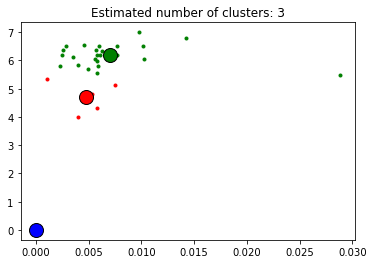

In [8]:
# 绘制聚类结果
from itertools import cycle

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)

plt.show()

**注意**：绿色的簇代表没有从栅格中提取到栅格的特征信息，我将这些组单独放在一个簇中，该簇中一共有12组主基站的数据。

In [9]:
# 在labels中，我们可以获取到每一主基站中的分裂标签
print(len(labels))
labels

43


array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 2, 0, 1, 2, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1])

In [10]:
labels[14]

2

#### 组装数据集

In [13]:
# 经过聚类后的分组数据
X0 = pd.DataFrame(data[0][1])
X1 = pd.DataFrame(data[2][1])
X2 = pd.DataFrame(data[14][1])

for i in range(1,len(data)):
    if i != 0 and labels[i] == 1:
        X0.append(data[i][1])
    if i != 2 and labels[i] == 0:
        X1.append(data[i][1])
    if i != 14 and labels[i] == 2:
        X2.append(data[i][1])

In [14]:
print('X0:', X0.shape[0])
print('X1:', X1.shape[0])
print('X2:', X2.shape[0])

X0: 819
X1: 15
X2: 67


In [15]:
def rad(d):
    return d * math.pi / 180.0

# 地理坐标系：为球面坐标。 参考平面地是椭球面，坐标单位：经纬度；
# 投影坐标系：为平面坐标。参考平面地是水平面，坐标单位：米、千米等；
# 地理坐标转换到投影坐标的过程可理解为投影。（投影：将不规则的地球曲面转换为平面）

# 目前国内主要有三种地理坐标系
# 1、WGS84坐标系：即地球坐标系（World Geodetic System），国际上通用的坐标系。
# 设备包含的GPS芯片或者北斗芯片获取的经纬度一般都是为WGS84地理坐标系，目前谷歌地图采用的是WGS84坐标系（中国范围除外）。
# 2、GCJ02坐标系：即火星坐标系，国测局坐标系。是由中国国家测绘局制定。由WGS84坐标系经加密后的坐标系。谷歌中国和搜搜中国采用。
# 3、BD09坐标系：百度坐标系，GCJ02坐标系经加密后的坐标系。

# 投影：墨卡托投影、高斯-克吕格 (Gauss-Krüger) 投影
# 感兴趣的同学可以在https://desktop.arcgis.com/zh-cn/arcmap/10.3/guide-books/map-projections/list-of-supported-map-projections.htm深入了解

# gps两点间距离（单位为米）
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +
    math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

In [16]:
from sklearn.model_selection import train_test_split  # 数据集划分
from sklearn.ensemble import RandomForestRegressor

# 按照主机站进行分组训练
data = [X0,X1,X2]
med = []  # 中位数
mea = [] # 均方误差
nin = [] # 分位数
loss = [] # 总误差

# 总共43组
for i in range(len(data)):
    group = data[i] # 一组
    pre = []
    # 以相对坐标作为预测值
    X, Xe, Y, Ye = train_test_split(
        group, 
        group[['Longitude', 'Latitude', 'lo', 'la']], 
        test_size=0.2, 
        random_state=200)
    reg = RandomForestRegressor()
    reg.fit(X.iloc[:, 3:32], Y[['lo', 'la']].values)
    pred = reg.predict(Xe.iloc[:, 3:32])
    # 换回真实坐标计算误差
    for bias in pred:
        pre.append([bias[0] + group.iloc[0,-4], bias[1] + group.iloc[0,-3]])
    err = [distance(p,t) for p, t in zip(pre,Ye[['Longitude','Latitude']].values)]
    err = sorted(err)
    # 考虑每组样本不同
    loss.extend(err)
    med.append(np.median(err))
    mea.append(np.mean(err))
    nin.append( err[int(len(err)*0.9)])
    print(str(i) +"组误差：", np.median(err), np.mean(err), err[int(len(err)*0.9)])

# 所有组的误差
print("所有组的平均误差：", np.mean(med), np.mean(mea), np.mean(nin))

0组误差： 4.9 42.15426829268293 104.0
1组误差： 3.0 6.6000000000000005 15.5
2组误差： 14.3 34.114285714285714 74.7
所有组的平均误差： 7.400000000000001 27.622851335656218 64.73333333333333


所有组的平均误差： 7.400000000000001 27.622851335656218 64.73333333333333


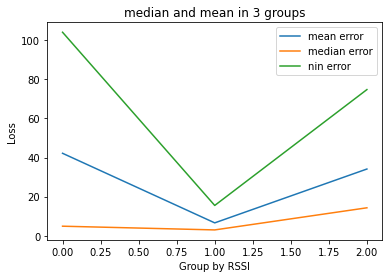

In [17]:
print("所有组的平均误差：", np.mean(med), np.mean(mea), np.mean(nin))

import matplotlib.pyplot as plt
plt.plot([0,1,2], mea, label='mean error')
plt.plot([0,1,2], med, label='median error')
plt.plot([0,1,2], nin, label='nin error')
plt.title('median and mean in 3 groups')

plt.xlabel("Group by RSSI")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 使用a中相对位置聚类结果进行分组预测定位

在a中，我们聚类结果有两个最优的K值，原始数据上是3，但由于聚类本身对距离非常敏感，所以我将相对位置进行归一化处理后的最优K值为4.这里采用K值为4进行分组训练预测定位。

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from matplotlib.pyplot import MultipleLocator # 设置刻度间隔

In [19]:
# 读取数据
df = pd.read_csv('../data/group_data.csv')

# 按照主机站进行分组
data = df.groupby(['RNCID_1','CellID_1'])
data = list(data)  # 共43个组

In [20]:
# 提取特征
# 选取所有组的特征信息
group_feature = []
for i in range(len(data)):
    dist = []
    for index, row in data[i][1].iterrows():
        d = np.sqrt(row['lo']**2 + row['la']**2)
        dist.append(d)
    group_feature.append([np.mean(dist), np.var(dist)])
X = np.array(group_feature)

In [21]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# 归一化
minmax = MinMaxScaler()
scaler_data = minmax.fit_transform(X)

0.6644810230818553


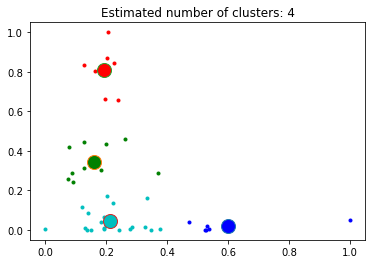

In [22]:
# 归一化处理有最优k值是4，绘制聚类结果
from itertools import cycle

model = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=200)
model.fit(scaler_data)

labels = model.labels_  # 获取聚类标签
cluster_centers = model.cluster_centers_  # 获取聚类中心
inertia = model.inertia_  # 获取聚类准则的总和

# print(labels)
# print(cluster_centers)
print(inertia)

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykaaafawadad")

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(scaler_data[my_members, 0], scaler_data[my_members, 1], col + '.')
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [23]:
# 查看分类标签
print('labels length', len(labels))
print(labels)

labels length 43
[1 2 0 0 2 3 3 0 0 1 3 2 2 3 2 3 0 3 3 3 3 1 3 1 1 1 1 2 3 1 2 1 3 3 0 3 1
 3 3 3 3 3 3]


In [41]:
labels[5]

0

In [32]:
# 组装数据集
# 经过聚类后的分组数据


X0 = pd.DataFrame(data[0][1])
X1 = pd.DataFrame(data[1][1])
X2 = pd.DataFrame(data[2][1])
X3 = pd.DataFrame(data[5][1])

for i in range(len(data)):
    if i != 0 and labels[i] == 1:
        X0.append(data[i][1])
    if i != 1 and labels[i] == 2:
        X1.append(data[i][1])
    if i != 2 and labels[i] == 0:
        X2.append(data[i][1])
    if i != 5 and labels[i] == 3:
        X3.append(data[i][1])

In [33]:
print('X0:', X0.shape[0])
print('X1:', X1.shape[0])
print('X2:', X2.shape[0])
print('X3:', X3.shape[0])
# 分的相对而言更加均匀

X0: 819
X1: 103
X2: 15
X3: 38


In [34]:
from sklearn.model_selection import train_test_split  # 数据集划分
from sklearn.ensemble import RandomForestRegressor
import math

# 按照主机站进行分组训练
data = [X0,X1,X2,X3]
med = []  # 中位数
mea = [] # 均方误差
nin = [] # 分位数
loss = [] # 总误差

# 总共43组
for i in range(len(data)):
    group = data[i] # 一组
    pre = []
    # 以相对坐标作为预测值
    X, Xe, Y, Ye = train_test_split(
        group, 
        group[['Longitude', 'Latitude', 'lo', 'la']], 
        test_size=0.2, 
        random_state=200)
    reg = RandomForestRegressor()
    reg.fit(X.iloc[:, 3:32], Y[['lo', 'la']].values)
    pred = reg.predict(Xe.iloc[:, 3:32])
    # 换回真实坐标计算误差
    for bias in pred:
        pre.append([bias[0] + group.iloc[0,-4], bias[1] + group.iloc[0,-3]])
    err = [distance(p,t) for p, t in zip(pre,Ye[['Longitude','Latitude']].values)]
    err = sorted(err)
    # 考虑每组样本不同
    loss.extend(err)
    med.append(np.median(err))
    mea.append(np.mean(err))
    nin.append( err[int(len(err)*0.9)])
    print(str(i) +"组误差：", np.median(err), np.mean(err), err[int(len(err)*0.9)])

# 所有组的误差
print("所有组的平均误差：", np.mean(med), np.mean(mea), np.mean(nin))

0组误差： 5.9 43.01341463414634 91.1
1组误差： 28.3 38.42380952380953 71.2
2组误差： 2.3 4.433333333333334 10.4
3组误差： 10.1 8.0625 12.0
所有组的平均误差： 11.65 23.483264372822305 46.175000000000004


所有组的平均误差： 11.65 23.483264372822305 46.175000000000004


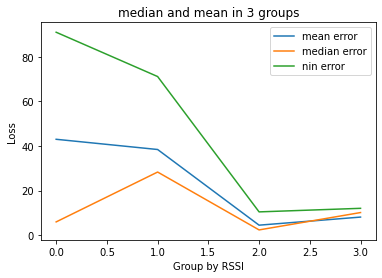

In [37]:
print("所有组的平均误差：", np.mean(med), np.mean(mea), np.mean(nin))

import matplotlib.pyplot as plt
plt.plot([0,1,2,3], mea, label='mean error')
plt.plot([0,1,2,3], med, label='median error')
plt.plot([0,1,2,3], nin, label='nin error')
plt.title('median and mean in 3 groups')

plt.xlabel("Group by RSSI")
plt.ylabel("Loss")
plt.legend()
plt.show()